# Load data

<https://www.kaggle.com/c/bike-sharing-demand>

In [1]:
import sage
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# Load data
df = sage.datasets.bike()
feature_names = df.columns.tolist()[:-3]

In [3]:
# Split data, with total count serving as regression target
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=123)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=123)
Y_train = train[:, -1].copy()
Y_val = val[:, -1].copy()
Y_test = test[:, -1].copy()
train = train[:, :-3].copy()
val = val[:, :-3].copy()
test = test[:, :-3].copy()

# Train model

In [4]:
import xgboost as xgb

In [5]:
# Set up data
dtrain = xgb.DMatrix(train, label=Y_train)
dval = xgb.DMatrix(val, label=Y_val)

# Parameters
param = {
    'max_depth' : 10,
    'objective': 'reg:squarederror',
    'nthread': 4
}
evallist = [(dtrain, 'train'), (dval, 'val')]
num_round = 50

# Train
model = xgb.train(param, dtrain, num_round, evallist, verbose_eval=False)

In [6]:
# Calculate performance
mean = np.mean(Y_train)
base_mse = np.mean((mean - Y_test) ** 2)
mse = np.mean((model.predict(xgb.DMatrix(test)) - Y_test) ** 2)

print('Base rate MSE = {:.2f}'.format(base_mse))
print('Model MSE = {:.2f}'.format(mse))

Base rate MSE = 31591.23
Model MSE = 1920.86


# Calculate feature importance (SAGE)

In [7]:
# Setup and calculate
imputer = sage.MarginalImputer(model, test[:512])
estimator = sage.PermutationEstimator(imputer, 'mse')
sage_values = estimator(test, Y_test)

  0%|          | 0/1 [00:00<?, ?it/s]

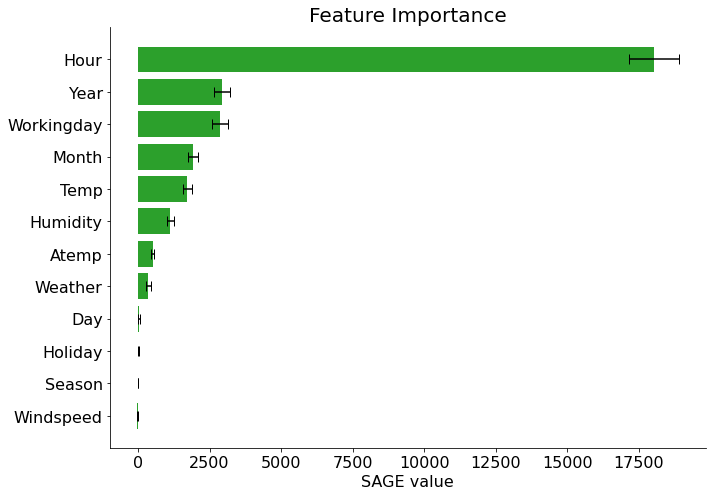

In [8]:
# Plot results
sage_values.plot(feature_names)

# Calculate model sensitivity (Shapley Effects)

In [9]:
# Setup and calculate
imputer = sage.MarginalImputer(model, test[:512])
estimator = sage.PermutationEstimator(imputer, 'mse')
sensitivity = estimator(test)

Calculating model sensitivity (Shapley Effects, not SAGE)


  0%|          | 0/1 [00:00<?, ?it/s]

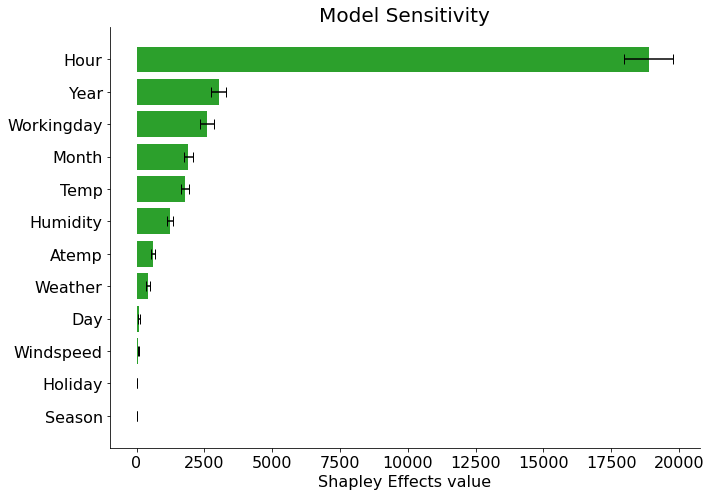

In [10]:
# Plot results
sensitivity.plot(feature_names, title='Model Sensitivity')